## Analysis of FFPE Prostate Dataset

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import squidpy as sq
import csv
from sklearn.metrics.pairwise import cosine_distances

In [2]:
ffpe_human_prostate = sc.read_visium('FFPE_Visium_Human_Prostate/',count_file='Visium_FFPE_Human_Normal_Prostate_filtered_feature_bc_matrix.h5')
ffpe_human_prostate.var_names_make_unique()

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
#Calculate some QC metrics for the data
ffpe_human_prostate.var["mt"] = ffpe_human_prostate.var_names.str.startswith("MT")
sc.pp.calculate_qc_metrics(ffpe_human_prostate, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


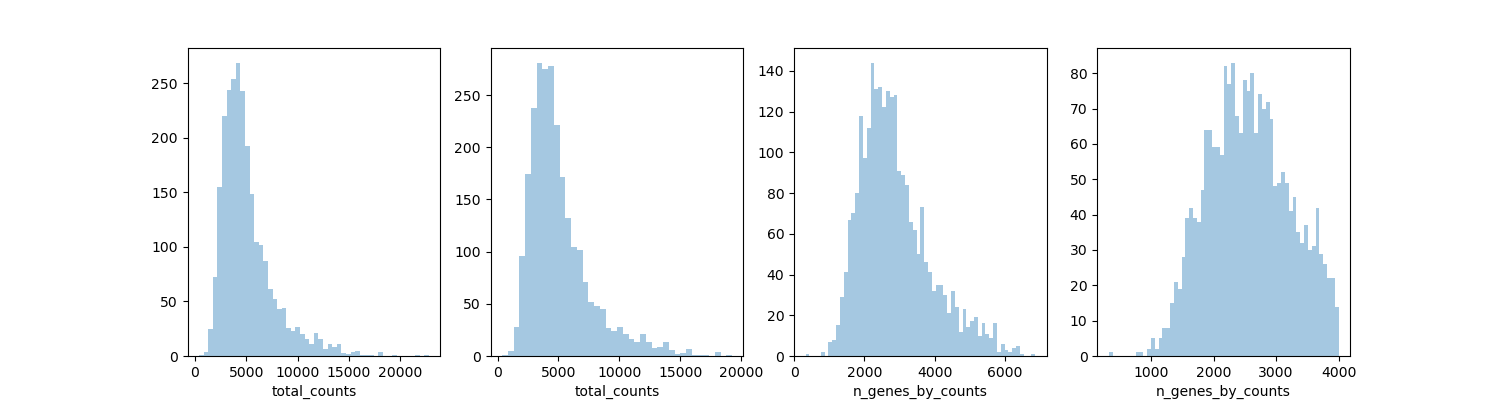

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_9388/2507783303.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_9388/2507783303.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

<IPython.core.display.Javascript object>


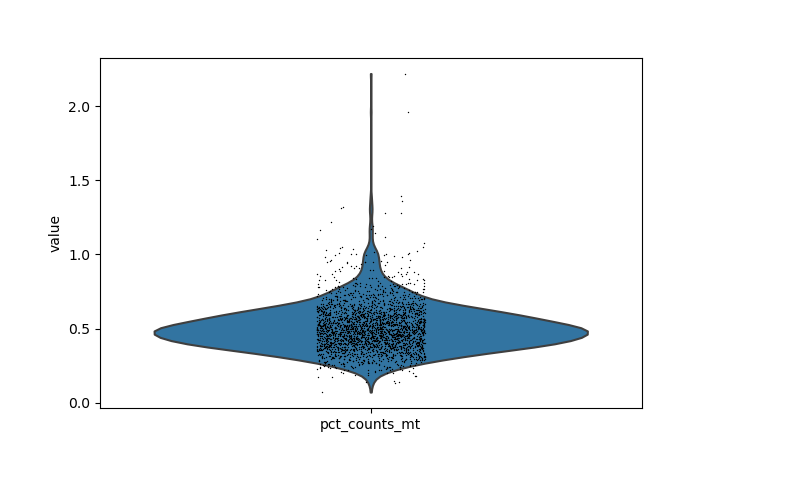

In [4]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_prostate.obs["total_counts"][ffpe_human_prostate.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"][ffpe_human_prostate.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ffpe_human_prostate,['pct_counts_mt'])

In [5]:
ffpe_human_prostate

AnnData object with n_obs × n_vars = 2543 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#Perform some filtering
sc.pp.filter_cells(ffpe_human_prostate, min_counts=2000)
print(f'Number of cells after min count filter: {ffpe_human_prostate.n_obs}')
sc.pp.filter_cells(ffpe_human_prostate, max_counts=15000)
print(f'Number of cells after max count filter: {ffpe_human_prostate.n_obs}')
ffpe_human_prostate = ffpe_human_prostate[ffpe_human_prostate.obs["pct_counts_mt"] < 10]
print(f"#cells after MT filter: {ffpe_human_prostate.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ffpe_human_prostate, min_cells=10)
print(f'Number of genes after cell filter: {ffpe_human_prostate.n_vars}')
sc.pp.filter_cells(ffpe_human_prostate, min_genes = 2000)
print(f'Number of cells after gene filter: {ffpe_human_prostate.n_obs}')

Number of cells after min count filter: 2477
Number of cells after max count filter: 2457
#cells after MT filter: 2457
Number of genes after cell filter: 14181
Number of cells after gene filter: 2051


/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [7]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ffpe_human_prostate, inplace=True)
sc.pp.log1p(ffpe_human_prostate)
sc.pp.highly_variable_genes(ffpe_human_prostate, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


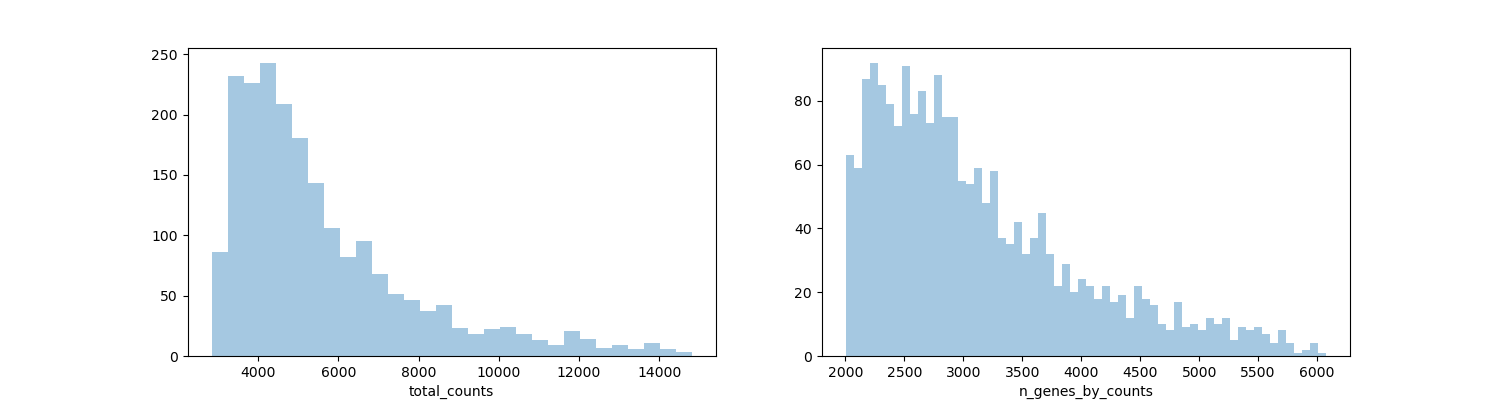

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_9388/3223433121.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_9388/3223433121.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe

<AxesSubplot: xlabel='n_genes_by_counts'>

In [9]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ffpe_human_prostate.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ffpe_human_prostate.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [10]:
#Perform next steps in cluster identification
sc.pp.pca(ffpe_human_prostate,n_comps=20)
sc.pp.neighbors(ffpe_human_prostate)
sc.tl.umap(ffpe_human_prostate)
sc.tl.leiden(ffpe_human_prostate, key_added='clusters')

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>


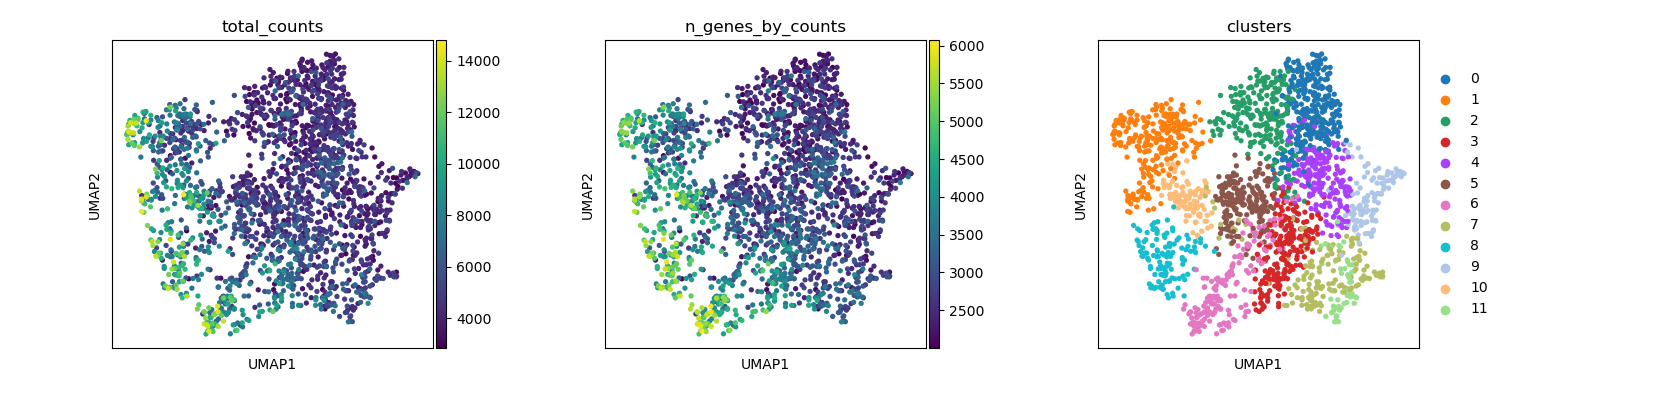

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [11]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ffpe_human_prostate, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


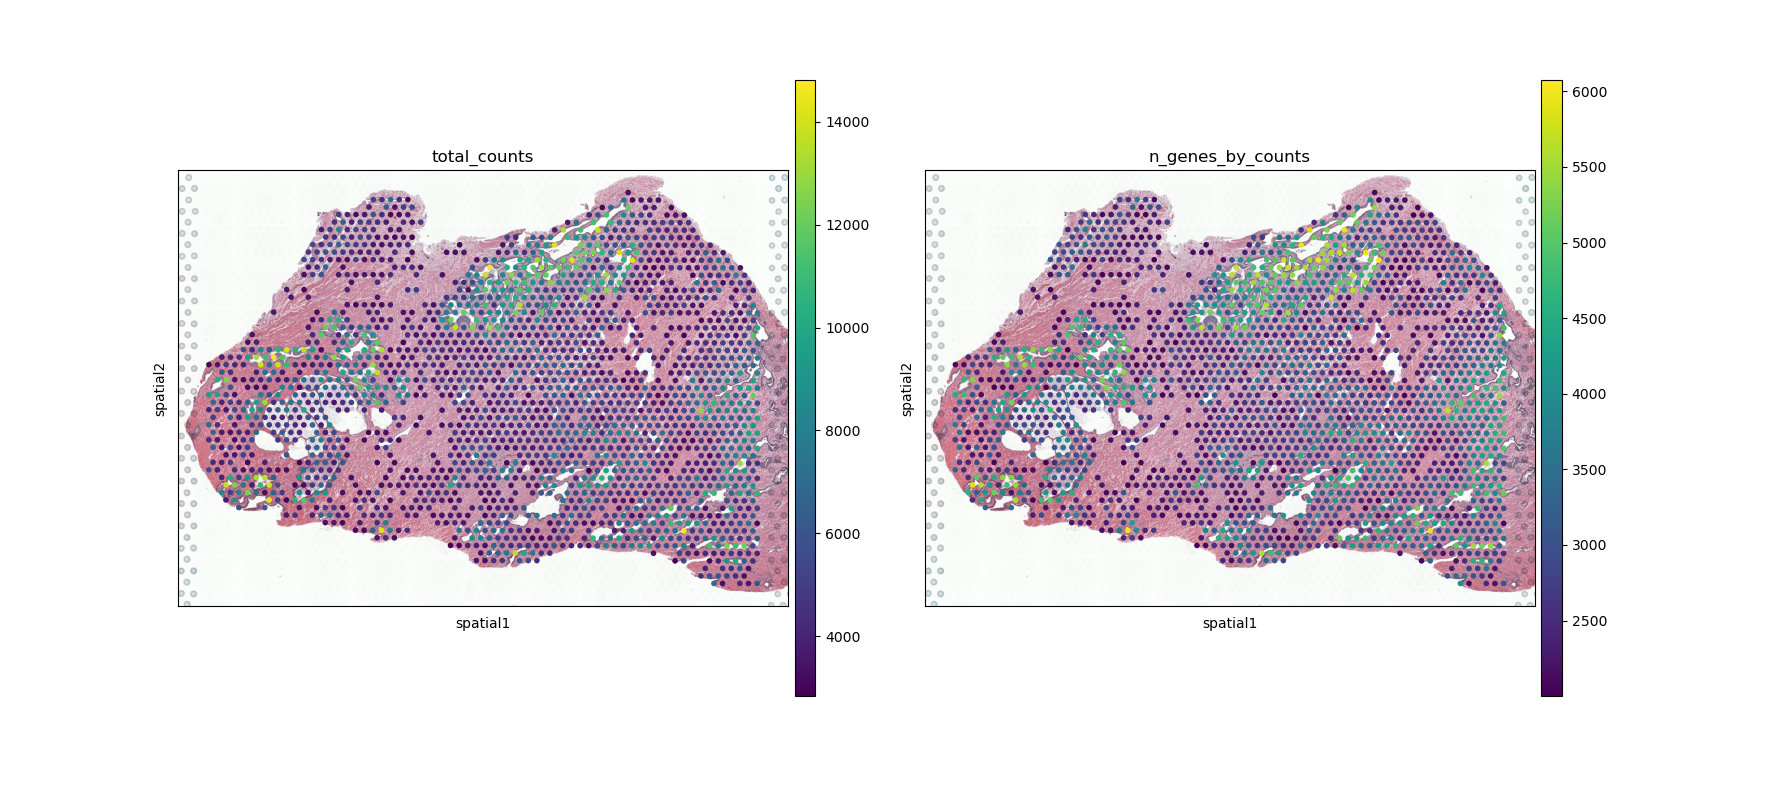

In [12]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ffpe_human_prostate, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


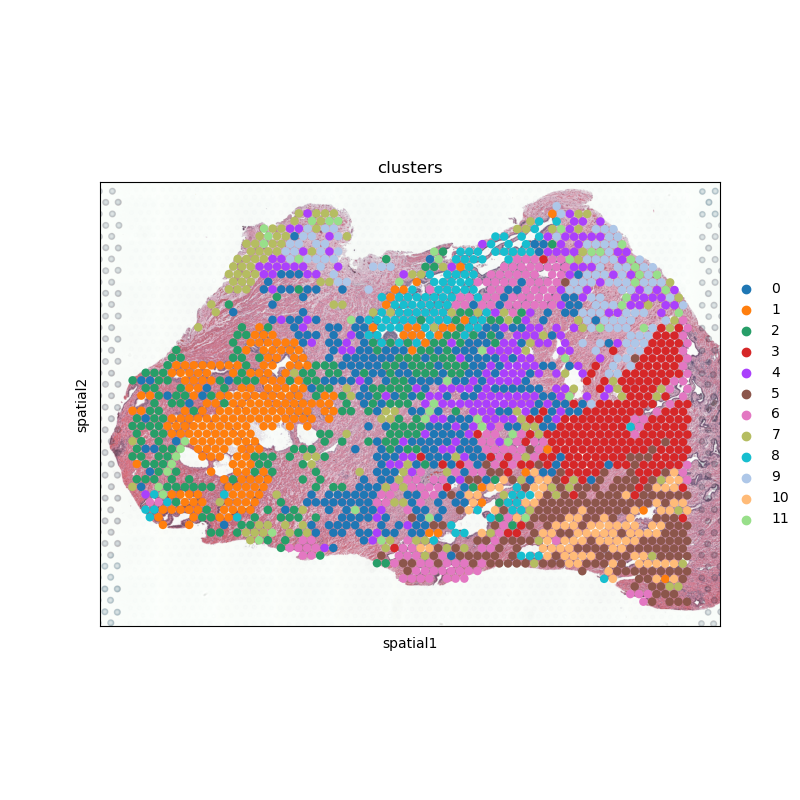

In [13]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ffpe_human_prostate, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


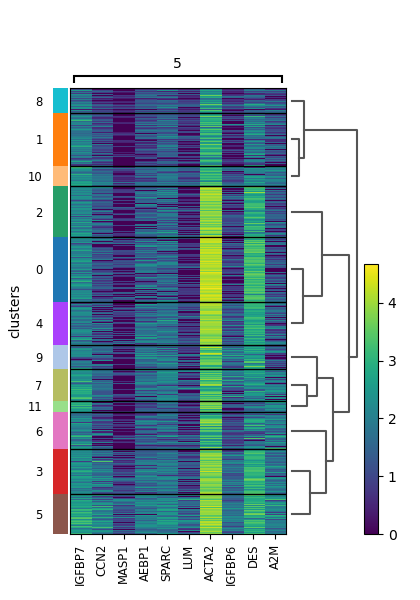

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


In [14]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ffpe_human_prostate, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ffpe_human_prostate, groups="5", n_genes=10, groupby="clusters")

### Now identify SVGs using squidpy

In [15]:
##Run moran's I on all genes not just HVGs
sq.gr.spatial_neighbors(ffpe_human_prostate, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(ffpe_human_prostate, genes=ffpe_human_prostate.var_names, use_raw=False, mode="moran")
ffpe_human_prostate.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
MSMB,0.726364,0.0,0.000164,0.0
KLK3,0.719783,0.0,0.000164,0.0
KLK2,0.666503,0.0,0.000164,0.0
ACPP,0.663995,0.0,0.000164,0.0
NPY,0.632708,0.0,0.000164,0.0
MYL9,0.563877,0.0,0.000164,0.0
MYLK,0.546527,0.0,0.000164,0.0
ACTG2,0.536122,0.0,0.000164,0.0
TAGLN,0.530700,0.0,0.000164,0.0
FLNA,0.526041,0.0,0.000164,0.0


In [16]:
moran_I = pd.DataFrame(ffpe_human_prostate.uns['moranI'].sort_values(ascending=False,by=['I']))

moran_I.to_csv('ffpe_human_prostate_squidpy_moranI_results_all.csv')

In [17]:
##Sort this so corrected pvalue is above 0.05 and I is above 0.5
moran_I = moran_I[moran_I['pval_norm_fdr_bh'] <=0.05]

##The expected value under Moran's spatial autocorrelation is E(I) = -1/(N-1) where N is number of samples or in this case genes
moran_I = moran_I[moran_I['I'] > 0.1]
moran_I

,I,pval_norm,var_norm,pval_norm_fdr_bh
MSMB,0.726364,0.000000,0.000164,0.000000
KLK3,0.719783,0.000000,0.000164,0.000000
KLK2,0.666503,0.000000,0.000164,0.000000
ACPP,0.663995,0.000000,0.000164,0.000000
NPY,0.632708,0.000000,0.000164,0.000000
...,...,...,...,...
TRAC,0.029409,0.009765,0.000164,0.049526
MIEF2,0.029374,0.009836,0.000164,0.049872
ITPKA,0.029367,0.009851,0.000164,0.049916
ARHGAP4,0.029367,0.009852,0.000164,0.049916


In [19]:
##Write these out to file until figure out how to filter
moran_I.to_csv("ffpe_human_prostate_squidpy_moranI_results_pval_fdr_bh_0.05_moransI_0.1.csv")